In [44]:
# Classic
import os
import time
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
import PIL.Image as Image

In [45]:
# Basic Torch
import torch
import torch.nn as nn
import torch.optim as optim

In [46]:
# For custom data loading and processing
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor
import torchvision.transforms.functional as F
from torchvision import models

In [47]:
# Special
from tqdm import tqdm # To see the progress bar
from torchsummary import summary

In [48]:
def apply_label_encoding_to_data(data: pd.DataFrame) -> pd.DataFrame:
    class_label_mapping = {}  # Dictionary to map class labels to indices
    unique_classes = data['label'].unique()  # Assuming 'label' is the column containing class labels in your CSV file

    for idx, class_label in enumerate(unique_classes):
        class_label_mapping[class_label] = idx

    # Convert the class labels in your dataset to numeric format
    data['label'] = data['label'].map(class_label_mapping)
    return data

In [49]:
IMAGE_DIMENSION = 256

In [50]:
# Define data transformations
data_transforms = {
    'train': T.Compose([
        T.Resize((IMAGE_DIMENSION, IMAGE_DIMENSION)),
        # T.RandomResizedCrop(224),
        # T.RandomHorizontalFlip(),

        T.ToTensor(),
        # T.Normalize([0.5], [0.5]),
        # T.Grayscale(num_output_channels=3),

        # T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': T.Compose([
        T.Resize((IMAGE_DIMENSION, IMAGE_DIMENSION)),
        # T.CenterCrop(224),

        T.ToTensor(),
        # T.Normalize([0.5], [0.5]),
        # T.Grayscale(num_output_channels=3),


        # T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [51]:
def cut_df(data: pd.DataFrame, bound: int) -> pd.DataFrame:
    if len(data) > bound:
        return data.drop([bound, len(data)-1], inplace=False)

In [52]:
class CustomImageDataset(Dataset):
    def __init__(self, labels_path, images_path, transform=None, target_transform=None):
        super().__init__()
        labels = pd.read_csv(labels_path)
        if target_transform:
            labels = target_transform(labels)

        labels = cut_df(labels, len(os.listdir(images_path)))

        self.img_labels = labels

        self.img_dir = images_path

        self.transform = transform

    def __len__(self):
        return min(np.max(self.img_labels['id']), len(os.listdir(self.img_dir)))
        # return len(self.img_labels) - 1

    def __getitem__(self, idx) -> tuple[torch.Tensor, int]:
        (id, label) = self.img_labels.iloc[idx]
        img_path = os.path.join(self.img_dir, str(id) + ".jpg")
        image = to_pil_image(read_image(img_path))

        # image=to_grayscale(image)
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


    @property
    def classes(self):
        return self.img_labels['label'].nunique()

In [53]:
# DATA_PATH = {
#     'train': {
#         'images': "../output/train",
#         'labels': "../train_labels.csv"
#     },
#     'test': {
#         'images': "../output/test",
#         'labels': "../test_labels.csv"
#     },
#     'val': {
#         'images': "../output/test",
#         'labels': "../test_labels.csv"
#     },
# }

DATA_PATH = {
    'train': {
        'images': "../extracted_cars/train",
        'labels': "../train_labels.csv"
    },
    'test': {
        'images': "../extracted_cars/test",
        'labels': "../test_labels.csv"
    },
    'val': {
        'images': "../extracted_cars/test",
        'labels': "../test_labels.csv"
    },
}

In [54]:
train_dataset = CustomImageDataset(
    labels_path=DATA_PATH['train']['labels'],
    images_path=DATA_PATH['train']['images'],
    transform=data_transforms['train'],
    target_transform=apply_label_encoding_to_data
)

test_dataset = CustomImageDataset(
    labels_path=DATA_PATH['test']['labels'],
    images_path=DATA_PATH['test']['images'],
    transform=data_transforms['test'],
    target_transform=apply_label_encoding_to_data
)

val_dataset = CustomImageDataset(
    labels_path=DATA_PATH['val']['labels'],
    images_path=DATA_PATH['val']['images'],
    transform=data_transforms['test'],
    target_transform=apply_label_encoding_to_data
)

In [55]:
len(train_dataset)

85

In [56]:
train_dataset[84][0].shape

torch.Size([3, 256, 256])

In [57]:
for image, label in val_dataset:
    if image.shape[0] != 3:
        print(label)

In [58]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [59]:
def show_one_image():
    train_features, train_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[0].permute(1, 2, 0)  # Permutations of channels
    label = train_labels[0]
    plt.imshow(img, cmap="RdBu")
    plt.show()
    print(f"Label: {label}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: torch.Size([64])


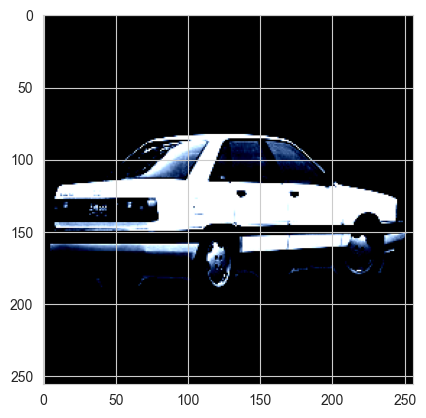

Label: 2


In [60]:
show_one_image()

In [61]:
def train_iteration(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    train_correct = 0
    train_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total

    train_accuracy = train_correct / train_total

    return epoch_loss, val_loss, train_accuracy, val_accuracy


In [62]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [63]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, scheduler=None):
    since = time.time()

    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            epoch_loss, val_loss, train_accuracy, val_accuracy = train_iteration(model, train_loader, val_loader, criterion, optimizer, device)
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}"
            )

            train_loss_history.append(epoch_loss)
            valid_loss_history.append(val_loss)

            train_accuracy_history.append(train_accuracy)
            valid_accuracy_history.append(val_accuracy)
            best_acc = max(best_acc, val_accuracy)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title="Model "
        )
    return model

In [65]:
NUM_CLASSES = train_dataset.classes

In [66]:
#mobilenet_v2
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
# model = models.resnet18(weights='IMAGENET1K_V1')

In [67]:
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

In [68]:
try:
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)
except AttributeError:
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=False),
        nn.Linear(in_features=model.fc.out_features,
                  out_features=NUM_CLASSES, bias=True)
    )

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-5)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/15 - Train Loss: 1.7204 - Val Loss: 1.7919 - Val Accuracy: 0.1500
Epoch 2/15 - Train Loss: 1.3939 - Val Loss: 1.7707 - Val Accuracy: 0.2500
Epoch 3/15 - Train Loss: 1.0668 - Val Loss: 1.7325 - Val Accuracy: 0.3000
Epoch 4/15 - Train Loss: 0.8778 - Val Loss: 1.7014 - Val Accuracy: 0.4000
Epoch 5/15 - Train Loss: 0.6658 - Val Loss: 1.6598 - Val Accuracy: 0.5500
Epoch 6/15 - Train Loss: 0.5463 - Val Loss: 1.5949 - Val Accuracy: 0.5500
Epoch 7/15 - Train Loss: 0.3861 - Val Loss: 1.5420 - Val Accuracy: 0.6000
Epoch 8/15 - Train Loss: 0.3262 - Val Loss: 1.5035 - Val Accuracy: 0.6000
Epoch 9/15 - Train Loss: 0.2522 - Val Loss: 1.4689 - Val Accuracy: 0.6000
Epoch 10/15 - Train Loss: 0.2055 - Val Loss: 1.4365 - Val Accuracy: 0.6000
Epoch 11/15 - Train Loss: 0.1762 - Val Loss: 1.4181 - Val Accuracy: 0.6000
Epoch 12/15 - Train Loss: 0.1231 - Val Loss: 1.3998 - Val Accuracy: 0.6500
Epoch 13/15 - Train Loss: 0.1129 - Val Loss: 1.3965 - Val Accuracy: 0.6500
Epoch 14/15 - Train Loss: 0.0952 -

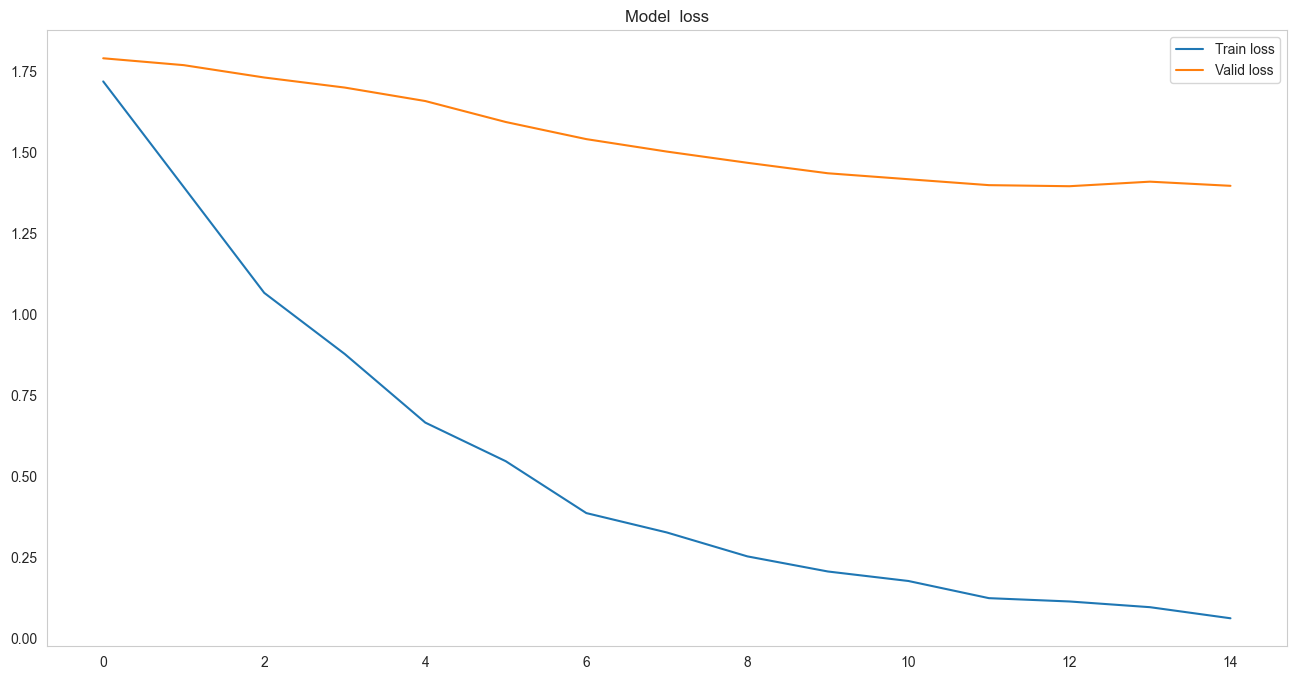

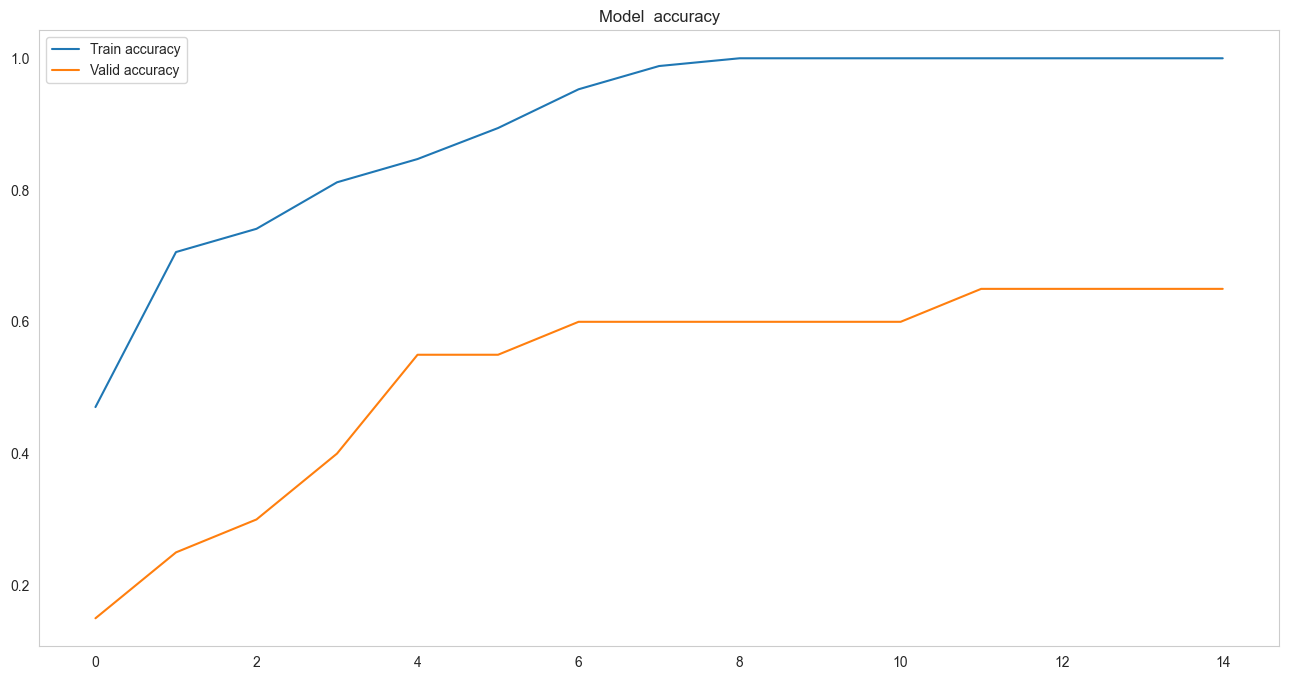

In [70]:
model = train_model(model=model,
                       train_loader=train_dataloader,
                       val_loader=val_dataloader,
                       criterion=criterion,
                       optimizer=optimizer,
                       num_epochs=num_epochs)

In [71]:
def save_model(model, path, entire_model=False):
    if entire_model:
        torch.save(model, path)
    else:
        torch.save(model.state_dict(), path)

In [72]:
model_path = '../model.pth'

In [73]:
save_model(model, path=model_path, entire_model=True)

In [74]:
model = torch.load(model_path)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [75]:
with torch.no_grad():
    print(np.argmax(model.forward(torch.unsqueeze(test_dataset[16][0], dim=0))))

tensor(4)


In [76]:
with torch.no_grad():
    for images, _ in test_dataloader:
        output = np.argmax(np.array(model.forward(images)), axis=1)
output

array([1, 3, 1, 4, 1, 3, 1, 1, 4, 1, 4, 4, 5, 4, 1, 1, 4, 1, 1, 1],
      dtype=int64)

In [79]:
for images, labels in test_dataloader:
    print(labels)

tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4])
